In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.cluster import KMeans
%matplotlib inline
import operator
import statsmodels as sm
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [60]:
df=pd.read_csv("http://data-melbournewater.opendata.arcgis.com/datasets/b2f0498806784746b72e98c49632d1b3_0.csv")

In [61]:
df["recordstart"]=df["recordstart"].str.replace('000Z','000000')
df["recordend"]=df["recordend"].str.replace('000Z','000000')

In [62]:
df["recordstart"]=df["recordstart"].map(lambda x: dt.datetime.fromisoformat(x))
df["recordend"]=df["recordend"].map(lambda x: dt.datetime.fromisoformat(x))

In [63]:
df=df.sort_values("recordstart",ascending=True)
df.reset_index(inplace=True)

In [64]:
df.columns=['killind','recordstart','recordend','ETP_Inflow_kL_s_1','ObjectId']
df=df.drop(columns='killind')

In [65]:
df['timedelta']=df['recordend']-df['recordstart']

In [66]:
filt=df['timedelta'].map(lambda x: (dt.timedelta.total_seconds(x)>3600)|(dt.timedelta.total_seconds(x)<3600))
filt2=df[filt]["recordstart"].map(lambda x: str(x)[11:20]=='16:00:00')
filtindex=df[filt][filt2].index
df.loc[filtindex,"recordstart"]=df[filt][filt2]["recordstart"].map(lambda x: x.replace(hour=15))

In [67]:
filt3=df[filt]["recordstart"].map(lambda x: str(x)[11:20]=='14:00:00')
filtindex2=df[filt][filt3].index
df.loc[filtindex2,"recordend"]=df[filt][filt3]["recordend"].map(lambda x: x.replace(hour=15))

In [68]:
df['timedelta']=df['recordend']-df['recordstart']
filt=df['timedelta'].map(lambda x: (dt.timedelta.total_seconds(x)>3600)|(dt.timedelta.total_seconds(x)<3600))

In [69]:
ts=df[["recordstart","ETP_Inflow_kL_s_1"]]
ts=ts.set_index(df["recordstart"])
ts=ts.drop(columns='recordstart')

In [70]:
def bincreate(bins):
    global bin_size, boundary_start, boundary_end, bin_mean, bin_sd
    bin_size=np.ceil(len(ts["ETP_Inflow_kL_s_1"])/bins)
    boundary_start=[bin_size*i+1 for i in range(0,bins)]
    boundary_end=[bin_size*i for i in range(1,bins+1)]
    bin_mean=[None]*bins
    bin_sd=[None]*bins

In [71]:
def binparametric(bins):  
    global bin_mean, bin_sd
    for i in range(0,bins):
        bin_mean[i]=ts["ETP_Inflow_kL_s_1"][int(boundary_start[i]):int(boundary_end[i])].mean()
        bin_sd[i]=ts["ETP_Inflow_kL_s_1"][int(boundary_start[i]):int(boundary_end[i])].std()
    bin_mean=np.array(bin_mean)
    bin_sd=np.array(bin_sd)

In [72]:
def binfill():
    global X
    X=[[bin_mean[0],bin_sd[0]]]
    for i in range(1,len(bin_mean)):
        X.append([bin_mean[i],bin_sd[i]])

In [73]:
def elbowtest():
    global sse,clusters,kmeans,ssediff,sseangle,ssecumdiffbefore,ssecumdiffafter,anglediffpos
    sse={}
    clusters={} 
    ssediff={}
    sseanglebefore={}
    sseangleafter={}
    ssecumdiffbefore={}
    ssecumdiffafter={}
    for i in range (1,nbins):
        kmeans=KMeans(n_clusters=i, random_state=0).fit(X)
        kmeans.labels_
        kmeans.cluster_centers_
        clusters[i]=kmeans.labels_
        sse[i]=kmeans.inertia_
    for i in range (1,(nbins-1)):
        ssediff[i]=sse[i]-sse[i+1]
        ssecumdiffbefore[i]=sse[1]-sse[i]
        ssecumdiffafter[i]=sse[i+1]-sse[nbins-1]
    for i in range (1,(nbins-2)):
        sseanglebefore[i]=((180*(np.arctan(1/ssediff[i]))))/np.pi  - (180*(np.arctan((i)/ssecumdiffbefore[i+1])))/np.pi 
        sseangleafter[i]=((180*(np.arctan(ssediff[i+1]/1))))/np.pi - (180*(np.arctan(ssecumdiffafter[i+1]/i)))/np.pi
    sseanglebefore=np.array(list(sseanglebefore.values()))
    sseangleafter=np.array(list(sseangleafter.values()))
    global anglediff
    anglediff=abs(sseangleafter-abs(sseanglebefore))
    anglediffpos=np.where(anglediff==min(anglediff))
    anglediffpos=int(np.where(anglediff==min(anglediff))+np.array(2))
    #Add 1 for zero index compensation and another 1 since first elbow occurs at position 2
    #print('elbow occurs at position ' + str(anglediffpos))

#sseangle2[i-1]=(180*(np.arctan(1/ssediff[i-1])
#print((min(sseangle.items(), key=operator.itemgetter(1))[0])+1)

In [74]:
def kfitter():
    global centers,kmeans,true_cluster,kmlab
    true_cluster=anglediffpos
    kmeans=KMeans(n_clusters=true_cluster, random_state=0).fit(X)
    kmlab=kmeans.labels_
    centers=kmeans.cluster_centers_

In [75]:
def distfinder():
    global mean_distance
    nrow=centers.shape[0]
    sum_matrix=np.zeros(shape=(nrow,nrow))
    for i in range (0,nrow):
        for j in range (0, nrow):
            sum_matrix[i,j]=np.sqrt(np.square(centers[i,0]-centers[j,0])+np.square(centers[i,1]-centers[j,1]))
    #Find maximum mean euclidian distance for selected number of centers and use that for classification
    unique_distances=np.unique(sum_matrix)
    mean_distance=sum(unique_distances/nrow)
    #print('mean k centroid distance is ' + str(mean_distance))

In [76]:
distance_list={}
for i in range (4,20):
    nbins=i
    bincreate(bins=nbins)
    binparametric(bins=nbins)
    binfill()
    elbowtest()
    kfitter()
    distfinder()
    distance_list[i]=mean_distance

true_bin=max(distance_list.items(), key=operator.itemgetter(1))[0]

In [77]:
nbins=true_bin
bincreate(bins=nbins)
binparametric(bins=nbins) 
binfill()
elbowtest()
kfitter()

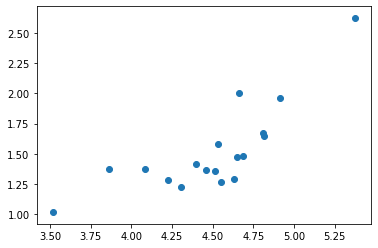

In [78]:
plt.scatter(bin_mean,bin_sd)

In [79]:
true_bin

18

In [80]:
kmlab

array([1, 1, 1, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0])

In [81]:
kmeans=KMeans(n_clusters=true_cluster, random_state=0).fit(X)
kmeans.labels_
kmeans.cluster_centers_
clusters[i]=kmeans.labels_
sse[i]=kmeans.inertia_

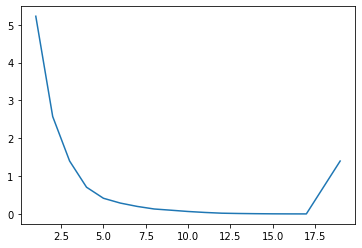

In [82]:
plt.plot(list(sse.keys()), list(sse.values()));

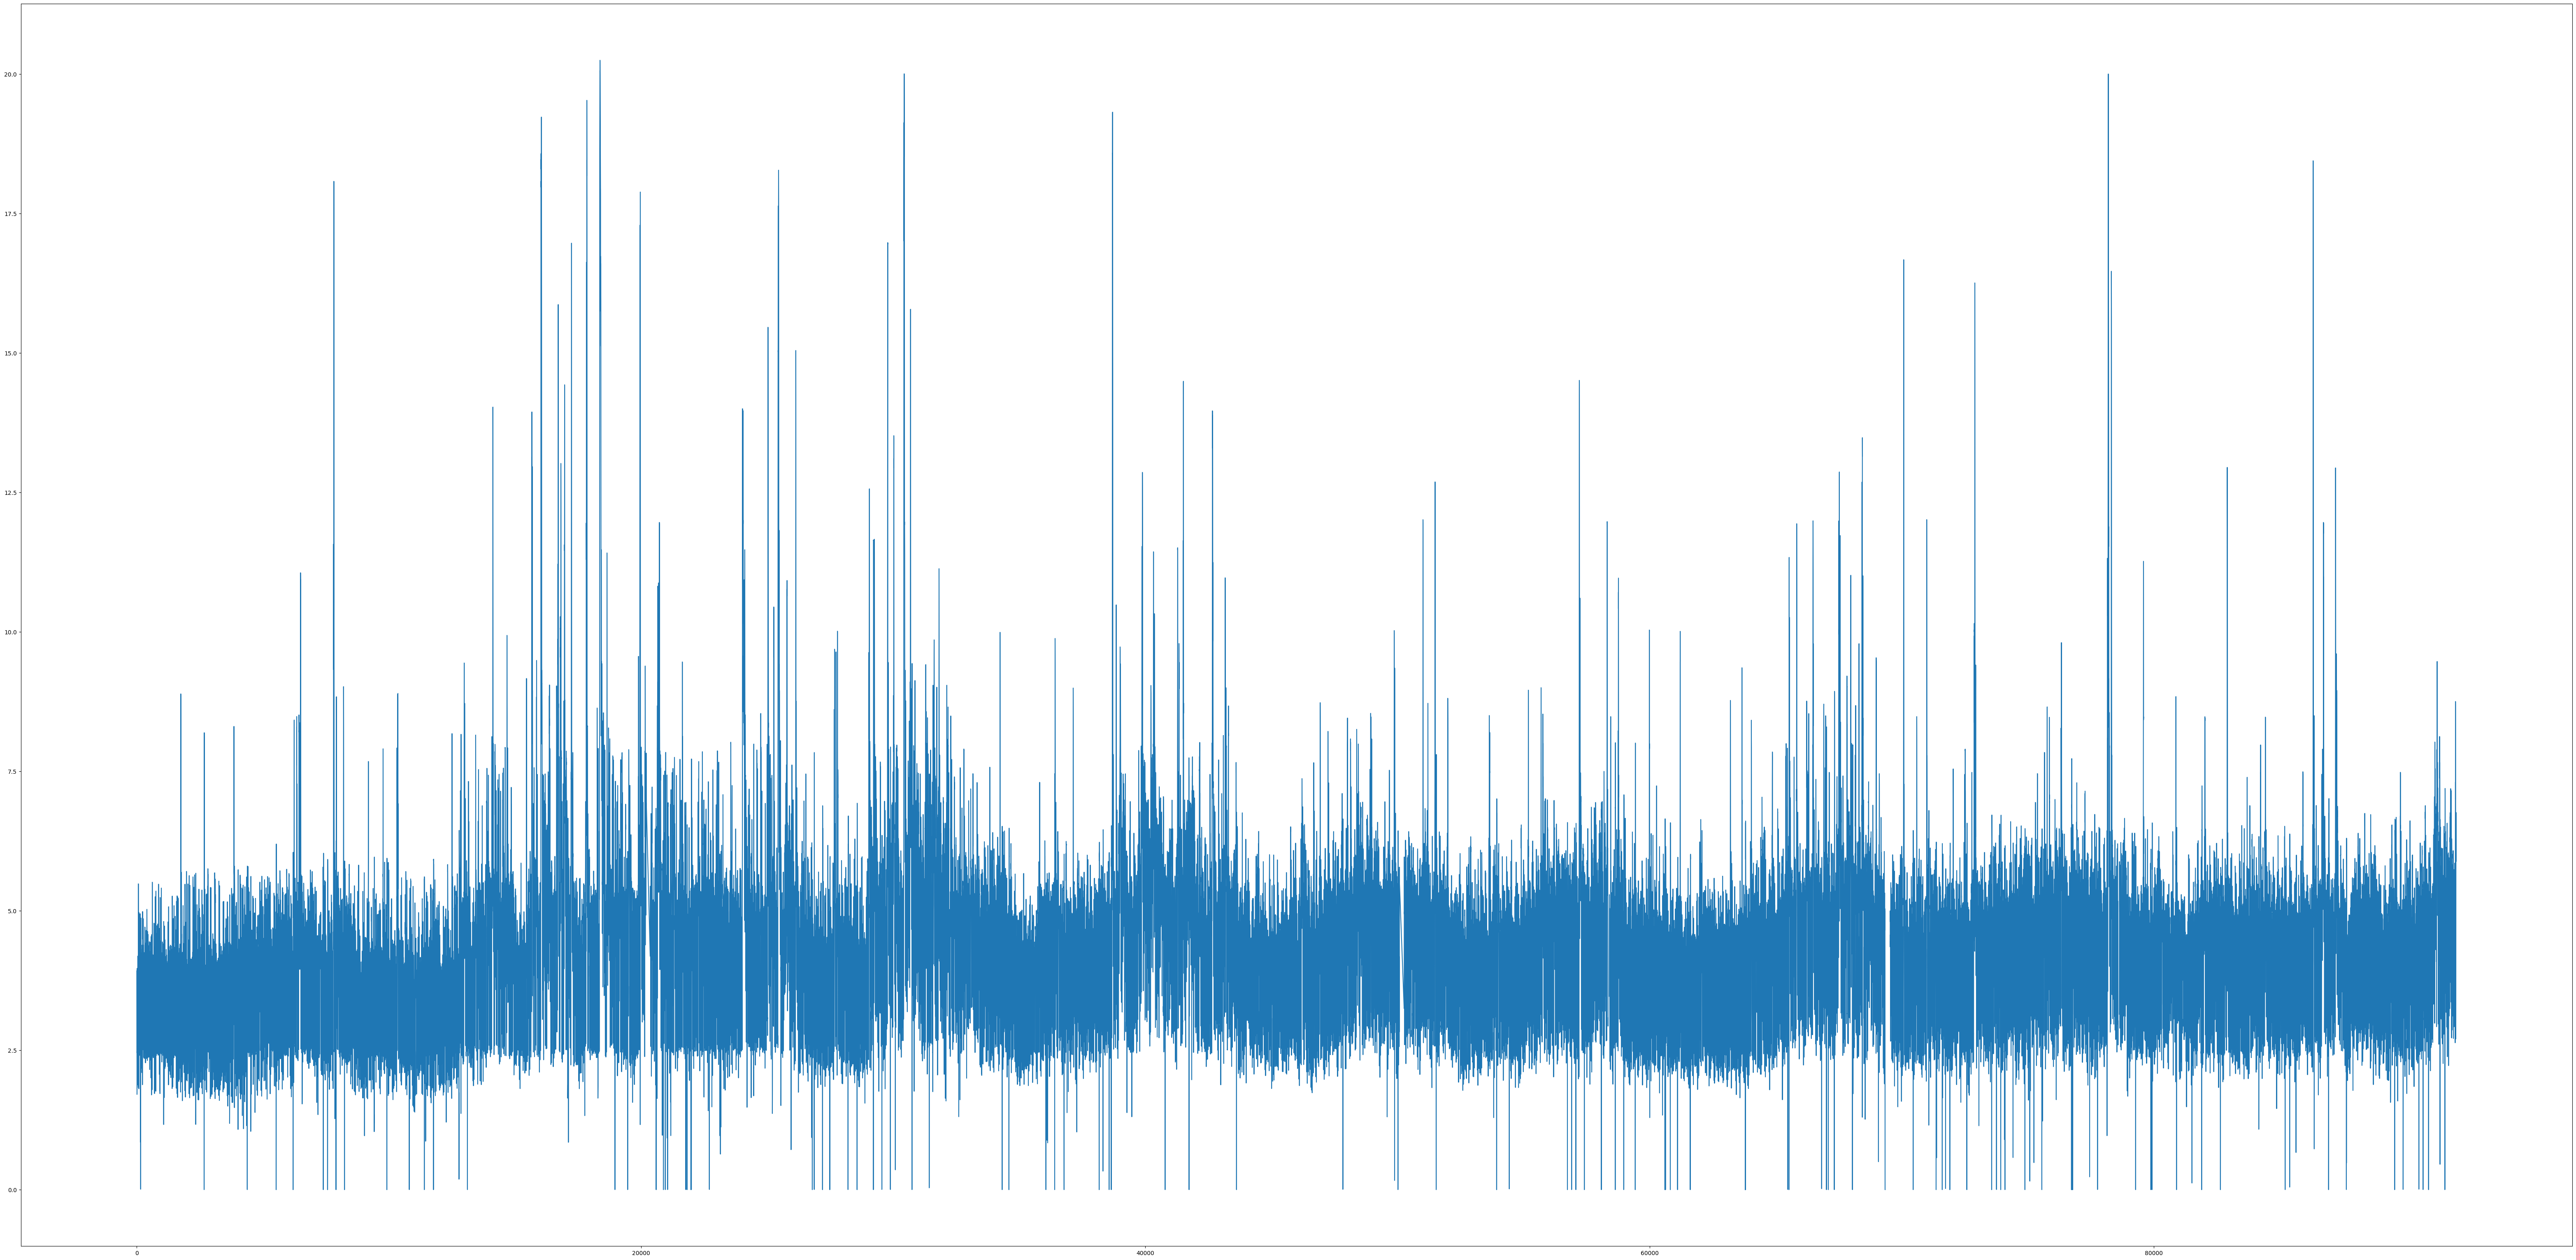

In [83]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(80, 40), dpi=100, facecolor='w', edgecolor='k')
plt.plot(df['ETP_Inflow_kL_s_1'])

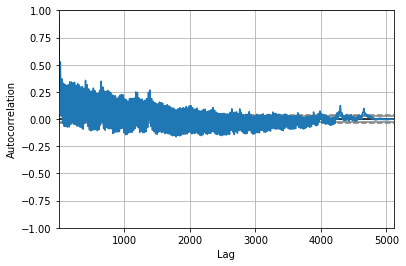

In [125]:
pd.plotting.autocorrelation_plot(ts[int(a*bin_size+1):int((a+1)*bin_size)].resample("1h").median())

In [55]:
a=sm.tsa.stattools.pacf(ts[int(bin_size+1):int(2*bin_size)], nlags=150, method='ywunbiased', alpha=None)

In [56]:
b=sm.tsa.stattools.acf(ts[int(bin_size+1):int(2*bin_size)], nlags=150, alpha=None, fft=True)

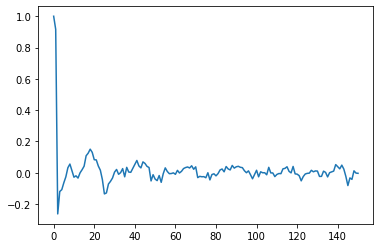

In [58]:
plt.plot(a)

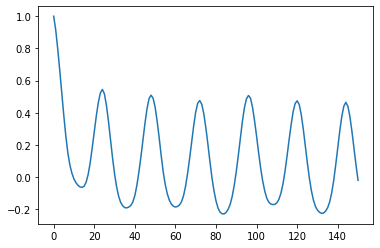

In [57]:
plt.plot(b)